# Trim video and IMU raw data using starting/ending movements performed by the participant. Ensure IMU and Video length consistency.

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from datetime import *
from imu_video_synch import *
from zurich_move_data_extraction import *
from utilities import *

/Users/linus/Code/imu_processing/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Video Side Steps
- Convert the video to MP4 for Labelbox 
- Import the metadata from the video
- Extract the exact frame start movement/end movement
- From these 2 frames: get cutting time
- Trim the video at the exact timestamp -> trimmed_video
- Extract the new number of frames of the trimmed video 
- Get the new start timestamp
- save the trimmed video as MP4 for labelbox 

In [3]:
# CHANGE HERE #TODO
participant_id = 'Hxx2'

In [4]:
path, video_path, imu_path = get_participant_paths(participant_id, study_folder='../data/CreateStudy')
print("Video Path:", video_path)
print("IMU Path:", imu_path)

Video Path: ../data/CreateStudy/Hxx2/Hxx2.MOV
IMU Path: ../data/CreateStudy/Hxx2/Hxx2.mat


In [5]:
# Import the metadata from the video
metadata = extract_metadata(video_path)
number_frames, fps, recording_time, creation_time, timestamps = metadata

In [6]:
# Use this to find the frames starting/ending the recording ie finding the starting and ending movements
# Starting: when the left hand goes up after the 30sec resting time
# Ending: when the left hand goes on the table just before the 30sec resting time 
# (exit by pressing q) 
read_video_frames(video_path)

2024-05-03 18:08:12.742 Python[38190:11106974] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


In [7]:
# Extract the exact frame start movement/end movement using OpenCV  
frame_start = 2460
frame_end = 2648

In [8]:
# Get Trimming parameters
video_start_timestamp, video_end_timestamp,trimmed_video_duration = get_trimmed_video_timestamps(frame_start, frame_end, timestamps)
start_trimming_time, end_trimming_time = get_trimming_times(frame_start, frame_end)

In [9]:
# Trim the video at the exact timestamp -> trimmed_video
trimmed_video = trim_video(video_path, start_trimming_time, end_trimming_time, path)
print(f"Trimmed video saved as: {trimmed_video}")

Trimmed video saved as: ../data/CreateStudy/Hxx2/trimmed_Hxx2.MOV


ffmpeg version 7.0 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino -

In [10]:
# Read the trimmed video frame by frame to ensure it is correct (exit by pressing q) 
read_video_frames(trimmed_video)

In [11]:
# Convert the trimmed video to MP4 format needed for Labelbox (labeling tool)
converted_trimmed_video = convert_from_mov_to_mp4(trimmed_video, path)

ffmpeg version 7.0 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino -

In [12]:
# Extract the new metadata of the trimmed video 
trimmed_number_frames,  trimmed_fps,  trimmed_recording_time, trimmed_creation_time,  trimmed_timestamps = extract_metadata(converted_trimmed_video)
print(trimmed_number_frames, trimmed_fps, trimmed_recording_time, trimmed_creation_time, trimmed_timestamps)

188 25 7.52 None None


In [13]:
# Create MP4 videos (Left and Right Wrists) for Labelbox
# Filenames
trimmed_video_filename = 'converted_trimmed_' + participant_id + '.MOV.mp4'
labelbox_video_LW_filename = participant_id + '_LW.mp4'
labelbox_video_RW_filename = participant_id + '_RW.mp4'

# Paths
trimmed_video_path = os.path.join(path, trimmed_video_filename)
labelbox_video_LW_path = os.path.join(path, labelbox_video_LW_filename)
labelbox_video_RW_path = os.path.join(path, labelbox_video_RW_filename)

# Copy videos
labelbox_video_LW_filename = copy_video_with_new_name(trimmed_video_path, labelbox_video_LW_path)
labelbox_video_RW_filename = copy_video_with_new_name(trimmed_video_path, labelbox_video_RW_path)

Video copied: '../data/CreateStudy/Hxx2/converted_trimmed_Hxx2.MOV.mp4' -> '../data/CreateStudy/Hxx2/Hxx2_LW.mp4'
Video copied: '../data/CreateStudy/Hxx2/converted_trimmed_Hxx2.MOV.mp4' -> '../data/CreateStudy/Hxx2/Hxx2_RW.mp4'


ffmpeg version 7.0 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino -

In [14]:
# Extract the new metadata of the trimmed video 
trimmed_video_filename = 'converted_trimmed_' + participant_id + '.MOV.mp4'
trimmed_video_path = os.path.join(path, trimmed_video_filename)
number_frames_trimmed_video,  _,  _, _,  _ = extract_metadata(trimmed_video_path)

In [15]:
# Split and saved on the device the MP4 videos for both wrists into 1min videos (easier for labeling)
output_folder_LW = os.path.join(path, 'splitted_videos_LW')
output_folder_RW = os.path.join(path, 'splitted_videos_RW')
split_video_into_segments(labelbox_video_LW_path,output_folder_LW, trimmed_number_frames)
split_video_into_segments(labelbox_video_RW_path,output_folder_RW, trimmed_number_frames)

Segment 1 saved: ../data/CreateStudy/Hxx2/splitted_videos_LW/Hxx2_LW_1.mp4
Video splitting completed!
Total number of frames in the segments matches the trimmed number of frames.
Segment 1 saved: ../data/CreateStudy/Hxx2/splitted_videos_RW/Hxx2_RW_1.mp4
Video splitting completed!
Total number of frames in the segments matches the trimmed number of frames.


## IMU side Steps

- From the start timestamp and number of frame, extract the new IMU data
- Ensure 2 * trimmed_video_frames (25Hz) = number_sample_IMU (50Hz)
- The starting peak of acceleration should match the start of the new trimmed data 
- The end of the acceleration peak should match the end of the cut

### ZM data extraction
Run the three cells below if you are using legacy wrist and chest ZM Data

In [18]:
# Define the sensor placements, sensor features, and dataframe features
sensor_placement = ['LW', 'chest', 'RW']
matlab_sensor_features = ['acc', 'gyro', 'quat', 'accHiG', 'magneto', 'press']
sensor_features = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'quat_0', 'quat_1', 'quat_2',
                   'quat_3', 'accHiG_x', 'accHiG_y', 'accHiG_z', 'magneto_x', 'magneto_y', 'magneto_z', 'press']
sensor_9DOF_features = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ',
                       'magnetoX', 'magnetoY', 'magnetoZ']
sensor_acc_features =  ['acc_x', 'acc_y', 'acc_z']


#Extract useful data from the IMU data file
header = extract_header_data_from_mat_file(imu_path)
sampling_freq =get_sampling_freq(header)
time_array = extract_time_data_from_mat_file(imu_path)
recording_time = get_recording_time(time_array)
dfs = extract_sensors_data_from_mat_file(imu_path, sensor_placement, matlab_sensor_features, sensor_features)
#Usefull export to csv (for SimuLOOP script)
#export_to_csv(file_path, dfs, sensor_placement, matlab_sensor_features, sensor_features)
acc_LW = dfs['LW'][['acc_x', 'acc_y', 'acc_z']]
acc_RW = dfs['RW'][['acc_x', 'acc_y', 'acc_z']]
gyro_LW = dfs['LW'][['gyro_x', 'gyro_y', 'gyro_z']]
gyro_RW = dfs['RW'][['gyro_x', 'gyro_y', 'gyro_z']]
mag_LW = dfs['LW'][['magneto_x', 'magneto_y', 'magneto_z']]
quat_sensor_LW = dfs['LW'][['quat_0', 'quat_1', 'quat_2','quat_3']]
LW_data = dfs['LW']
RW_data = dfs['RW']
chest_data = dfs['chest']
IMU_start_timestamp, IMU_end_timestamp = get_datetime_timestamp(header)

2023-08-30 10:19:51.000000 2023-08-30 10:36:55.000000


In [19]:
# Get all timestamps
timestamps_array = create_timestamps(IMU_start_timestamp, IMU_end_timestamp, 50)

In [20]:
# Add timestamps to raw data (needed for trimming step)
LW_data = pd.concat([timestamps_array, LW_data], axis=1)
RW_data = pd.concat([timestamps_array, RW_data], axis=1)
chest_data = pd.concat([timestamps_array, chest_data], axis=1)

### Axivity data extraction
Run the four cells below if you are using Axivity Data from the left and right wrist.

In [16]:
sensor_features = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [17]:
LW_filename = participant_id+'_LW.csv'
RW_filename = participant_id+'_RW.csv'
LW_data = extract_sensors_data_from_axivity_file(os.path.join(path, LW_filename), sensor_features)
RW_data = extract_sensors_data_from_axivity_file(os.path.join(path, RW_filename), sensor_features)

In [18]:
acc_LW = LW_data[['acc_x', 'acc_y', 'acc_z']]
acc_RW = RW_data[['acc_x', 'acc_y', 'acc_z']]
gyro_LW = LW_data[['gyro_x', 'gyro_y', 'gyro_z']]
gyro_RW = RW_data[['gyro_x', 'gyro_y', 'gyro_z']]

In [19]:
IMU_start_timestamp, IMU_end_timestamp = get_datetime_timestamp_Axivity(RW_data.index[0], RW_data.index[-1])
# Get all timestamps
timestamps_array = create_timestamps(IMU_start_timestamp, IMU_end_timestamp, 50)
# Add timestamps to raw data (needed for trimming step)
LW_data.reset_index(drop=True, inplace=True)
RW_data.reset_index(drop=True, inplace=True)
LW_data = pd.concat([timestamps_array, LW_data], axis=1)
RW_data = pd.concat([timestamps_array, RW_data], axis=1)

2024-05-03 11:28:41.309 2024-05-03 11:30:40.428


### Check acceleration magnitude

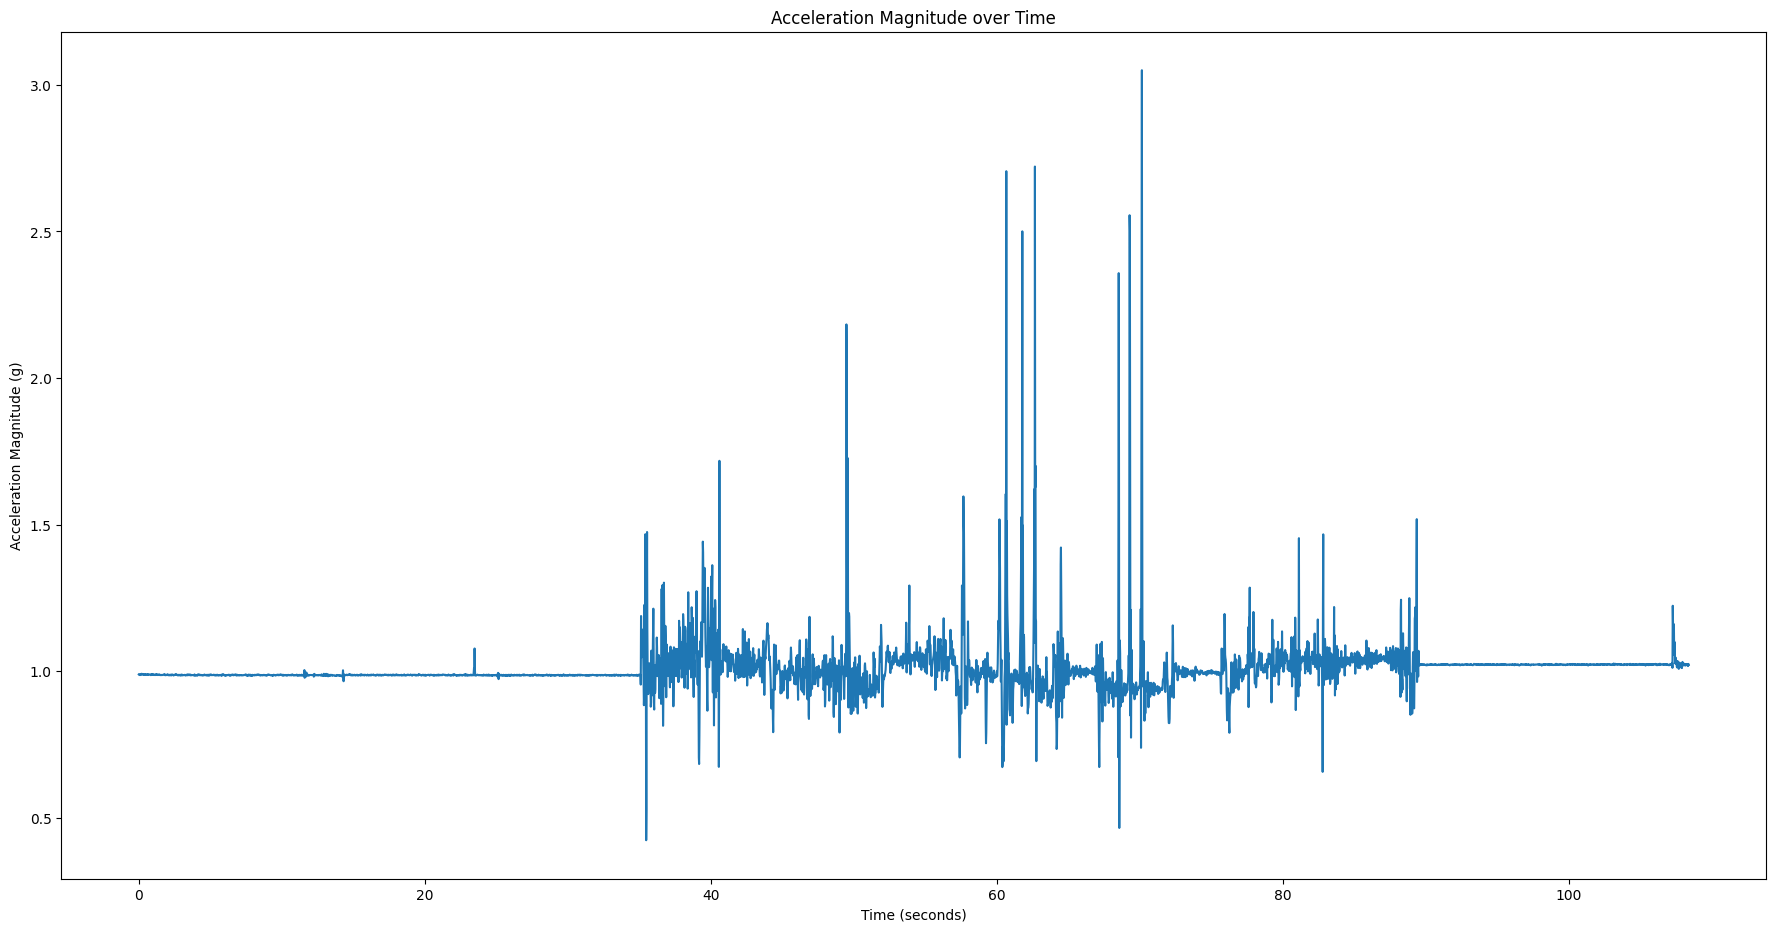

In [20]:
plot_acceleration_magnitude(LW_data,50)

### Trim IMU data

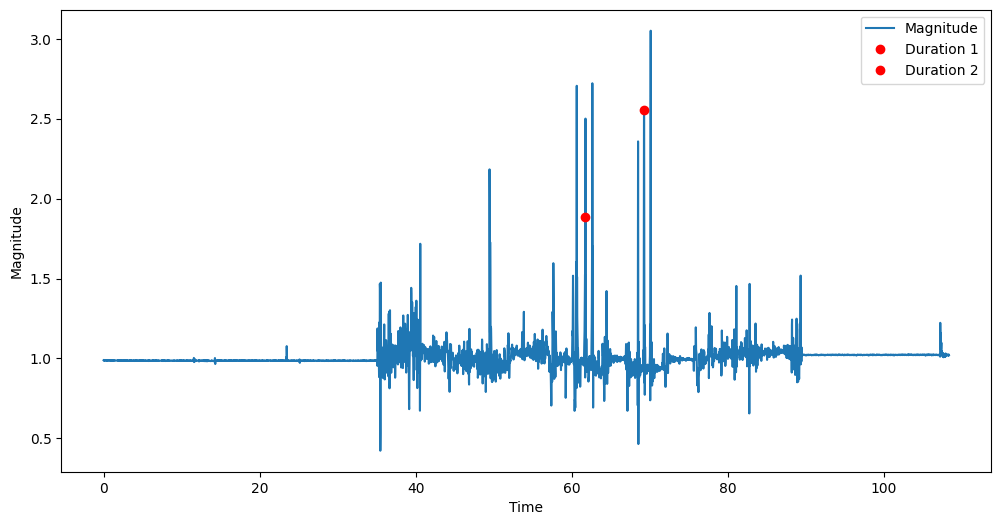

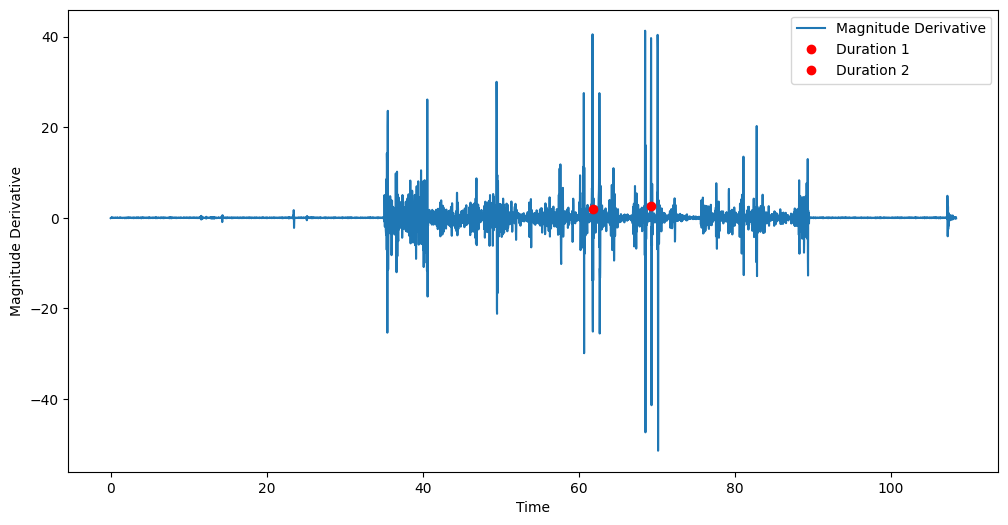

Duration 1: 61.76
Duration 2: 69.26
Number of Samples: 376
Number of Video Frames: 188
Conditions ok


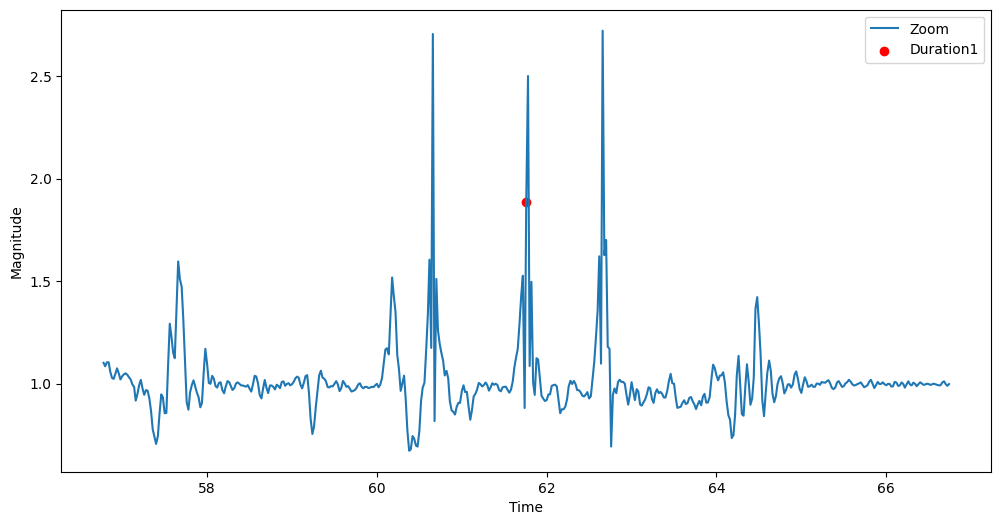

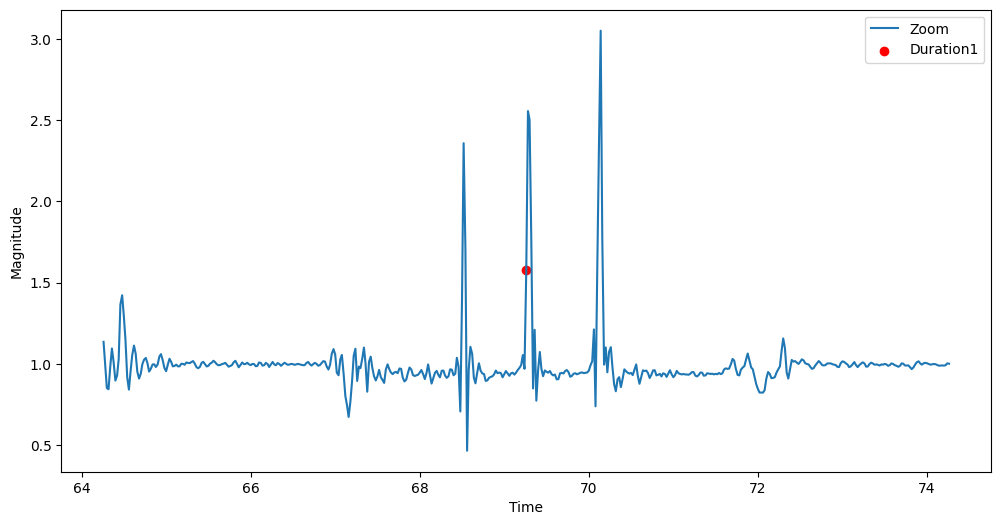

In [26]:
# CHANGE HERE #TODO
# Will modify the position of the red dot on the plot below
duration1 = 61.76
using_Axivity = True
# Code to set the starting red point of the IMU data.
# Should match the exact moment when the participant moved after the 30sec of resting. 
# Look for flat data during 30sec, then the red dot set by duration1 should be at
# the edge of the end of this flat data period
# duration2 is computed based on the duration of the previously trimmed video to
# ensure data IMU and data video will match exactly 
LW_data,  duration1, duration2 = plot_acceleration_with_timepoints(LW_data, duration1,
                                                                   trimmed_number_frames, trimmed_recording_time)

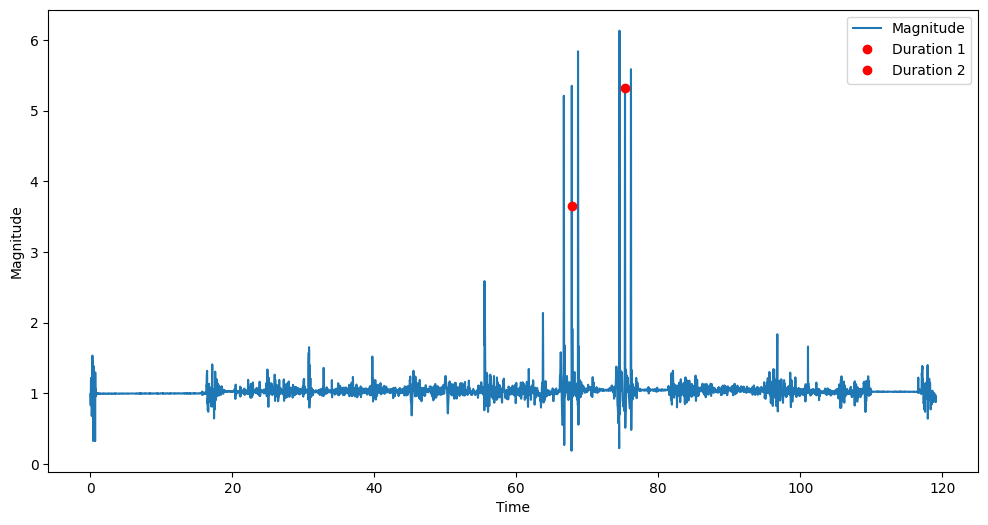

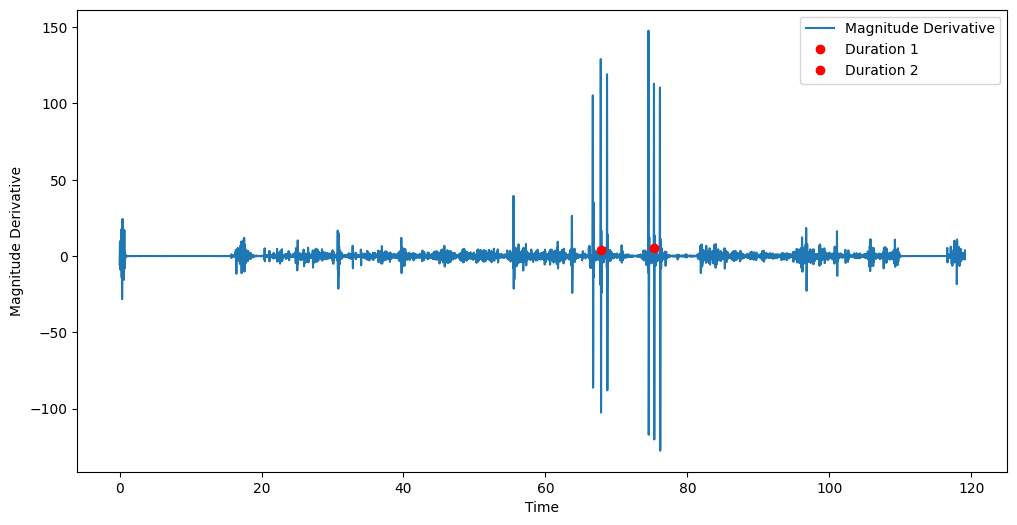

Duration 1: 67.8
Duration 2: 75.3
Number of Samples: 376
Number of Video Frames: 188
Conditions ok


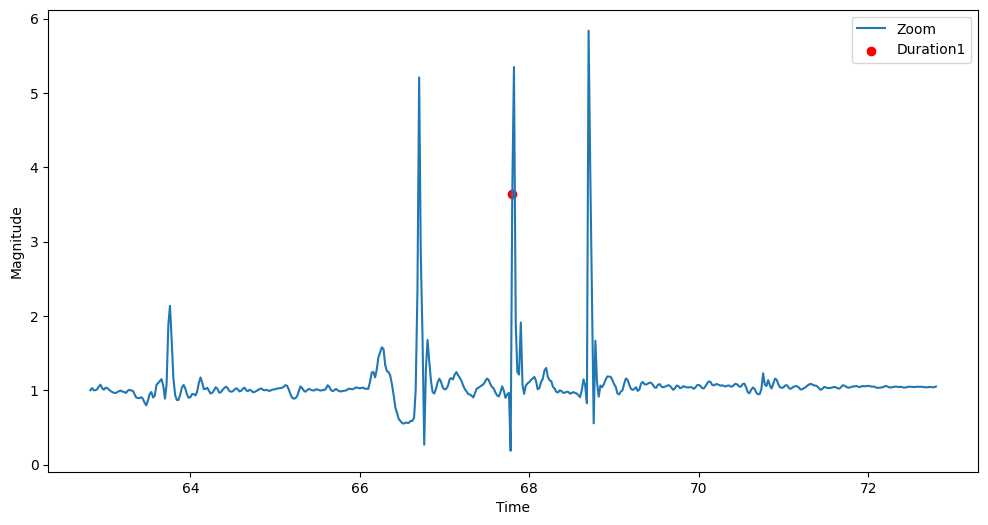

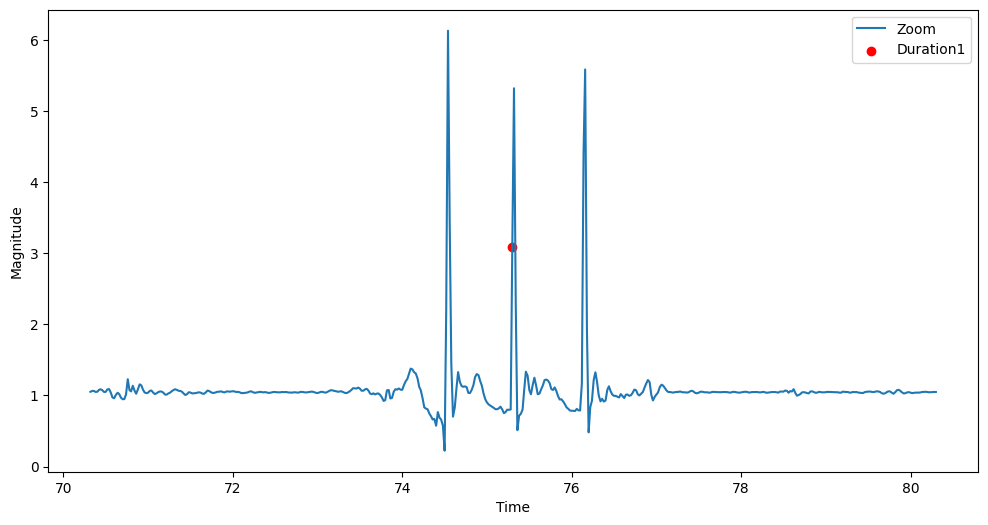

In [30]:
if not using_Axivity:
    duration1_RW = duration1
    duration2_RW = duration2

# CHANGE HERE #TODO
# Since Axivity sensors are not synced, identify the starting movement also for the right hand manually
# Will modify the position of the red dot on the plot below
duration1_RW = 67.8
if using_Axivity:
    RW_data,  duration1_RW, duration2_RW = plot_acceleration_with_timepoints(RW_data, duration1_RW,
                                                                       trimmed_number_frames, trimmed_recording_time)

In [33]:
# Trim the IMU data using the two fixed timestamps
LW_trimmed_data = trim_data(LW_data, duration1, duration2)
RW_trimmed_data = trim_data(RW_data, duration1_RW, duration2_RW)
chest_trimmed_data = None
if not using_Axivity:
    chest_trimmed_data = trim_data(chest_data, duration1, duration2)

In [34]:
# Save data inside the participant folder
# trimmed datasets
# parameters chosenfor the video and for the IMU trimming 
save_data(path, participant_id, frame_start, frame_end, duration1, LW_trimmed_data, RW_trimmed_data, chest_trimmed_data, using_Axivity, duration1_RW)

The integers have been saved to the file: '../data/CreateStudy/Hxx2/Hxx2_video_parameters.txt'
Video parameters saved.
Trimmed data for LW saved to: ../data/CreateStudy/Hxx2/trimmed_LW_data.csv
Trimmed data for RW saved to: ../data/CreateStudy/Hxx2/trimmed_RW_data.csv


: 